# 

In [1]:
from parameter_tuning import train_model
from rnn_gaussian import PredictTime
import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
import numpy as np
from evaluation import evaluate_model, bin_plot
import random
from data_gen import Datagen

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)



Using device:  cuda


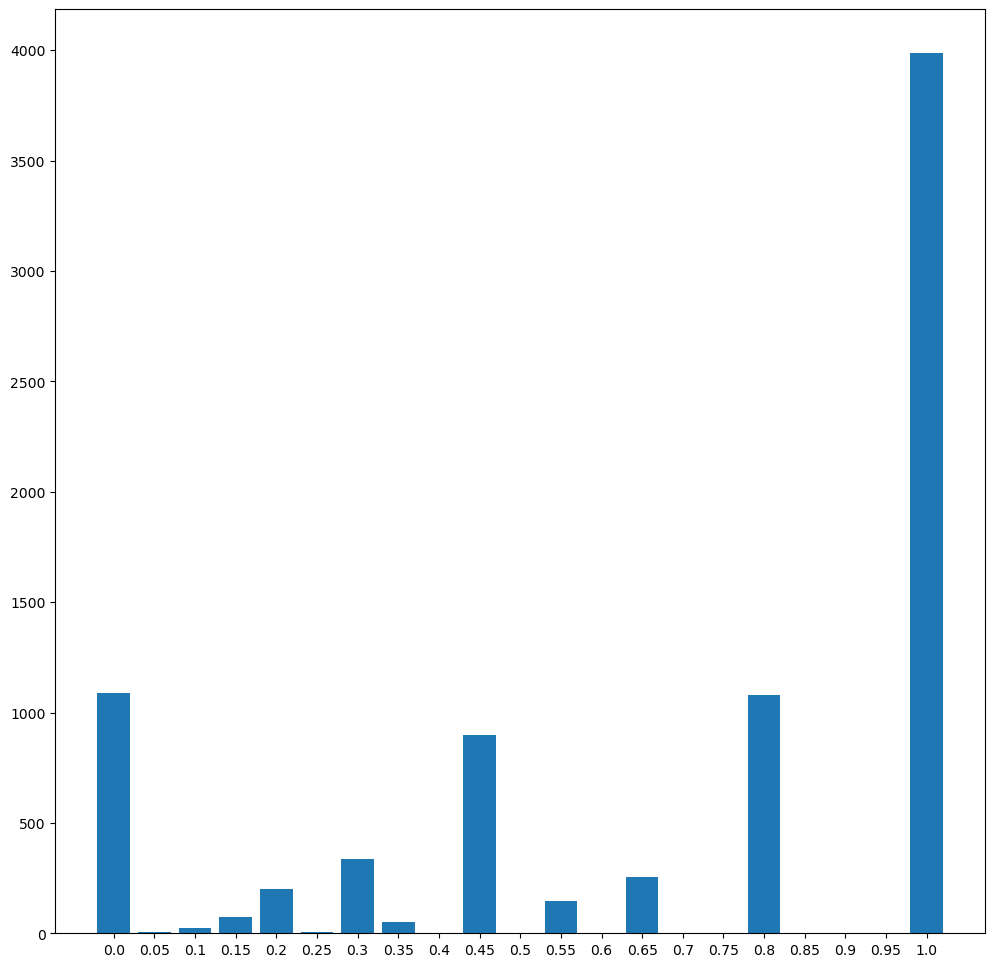

In [2]:
gen = Datagen(device)

x, y = gen.get_true_data(10)


bin_plot(y, 0, 1, None, 0.05)


In [3]:
import random

# Hyperparameters
sequence_length = [2*i for i in range(4,16)] # 2-20 increments of two
hidden_layers = [1,2]*2 # 1 and 2
hidden_1 = [2**i for i in range(5,10)] # 2^4 to 2^9
hidden_2 =[2**i for i in range(2, 5)] # 2^2 to 2^5
variance = [0.001, 0.01, 0.005, 0.05]
lr = [0.001, 0.01, 0.1, 0.005] # stop at 0.005
data_probability = [i/5 for i in range(1,6)]
noise_in_model = [True, False]
epochs = 1000000000
optimizer = [optim.Adam, optim.SGD]
print(hidden_layers)

options = []

for seq_len in sequence_length:
    for layers in hidden_layers:
        for h1 in hidden_1:
            for h2 in hidden_2:
                for l in lr:
                    for v in variance:
                        for p in data_probability:
                            for n in noise_in_model:
                                entry = {}
                                entry["seq_len"] = seq_len
                                entry["layers"] = layers
                                entry["hidden1"] = h1
                                entry["hidden2"] = h2
                                entry["l"] = l
                                entry["variance"] = v
                                entry["data_prob"] = p
                                entry["noise_model"] = n
                                options.append(entry)
                
                                         
random.shuffle(options)    



[1, 2, 1, 2]


In [ ]:
from IPython.display import clear_output

best_model = None
best_history = [""]
best_config = None
best_score = 1
for entry in options:
    x_d, y_d = gen.get_generated_data(entry["seq_len"], entry["variance"], entry["data_prob"])
    x_t, y_t = gen.get_true_data(entry["seq_len"])
    
    model = PredictTime(input_size=x_d[0].size()[0],
                        output_size=y_d[0].size()[0],
                        hidden_layers=entry["layers"],
                        h1=entry["hidden1"],
                        h2=entry["hidden2"],
                        device=device,
                       noise=entry["noise_model"]).to(device)
    print("Running model: ", entry, " epochs: ", epochs)

    
    model, history = train_model(model=model,
                                 x_data=x_d,
                                 y_data=y_d,
                                 batch_size=100,
                                 epochs=epochs,
                                 loss=nn.MSELoss(),
                                 optimizer=optim.Adam)
    clear_output()
    if history[-1][1] < best_score:
        print("New best model:\nNew loss: ", history[-1], "\nOld loss:", best_history[-1], "\nHistory:" , history[-10:])
        best_model = model
        best_history = history
        best_score = history[-1][1]
        best_config = entry
        evaluate_model(best_model, x_t, y_t, entry)
    else:
        evaluate_model(model, x_t, y_t, entry)
        print("Old model still stands:\nCurrent loss: ", history[-1], "\nBest loss:", best_history[-1])
                                 

    

Featurizing p:   0%|          | 0/1000 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/3000 [00:00<?, ?it/s]

0.6420548408125748


/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Old model still stands:
Current loss:  [2540, tensor(0.0012), tensor(0.1907)] 
Best loss: [2970, tensor(0.0005), tensor(0.2240)]
Running model:  {'seq_len': 22, 'layers': 1, 'hidden1': 128, 'hidden2': 16, 'l': 0.1, 'variance': 0.05, 'data_prob': 0.2, 'noise_model': False}  epochs:  1000000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([60, 1])) that is different to the input size (torch.Size([60])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[0, tensor(0.0627), tensor(0.1352)]
[10, tensor(0.0611), tensor(0.1691)]
[20, tensor(0.0609), tensor(0.1330)]
[30, tensor(0.0602), tensor(0.1120)]
[40, tensor(0.0597), tensor(0.1660)]
[50, tensor(0.0590), tensor(0.1313)]
[60, tensor(0.0584), tensor(0.0855)]
[70, tensor(0.0573), tensor(0.0962)]
[80, tensor(0.0561), tensor(0.1225)]
[90, tensor(0.0547), tensor(0.1287)]
[100, tensor(0.0529), tensor(0.1344)]
[110, tensor(0.0513), tensor(0.1324)]
[120, tensor(0.0496), tensor(0.1522)]
[130, tensor(0.0480), tensor(0.1503)]
[140, tensor(0.0460), tensor(0.1159)]
[150, tensor(0.0442), tensor(0.1395)]
[160, tensor(0.0426), tensor(0.1547)]
[170, tensor(0.0421), tensor(0.2487)]
[180, tensor(0.0394), tensor(0.1440)]
[190, tensor(0.0377), tensor(0.0897)]
[200, tensor(0.0373), tensor(0.1488)]
[210, tensor(0.0350), tensor(0.1455)]
[220, tensor(0.0337), tensor(0.1071)]
[230, tensor(0.0326), tensor(0.1678)]
[240, tensor(0.0315), tensor(0.1087)]
[250, tensor(0.0304), tensor(0.1470)]
[260, tensor(0.0294), t

#### 